In [18]:
from collections import defaultdict
import gpytorch
import math
import matplotlib
# matplotlib.rc("../etc/config/stylesheet.mplstyle")
import matplotlib.pyplot as plt
plt.style.use("../etc/config/stylesheet.mplstyle")
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import torch
import tqdm.notebook as tqdm
from torchvision.datasets import CIFAR10



%matplotlib inline

# Large Neural Network Counterfactual.

In [19]:
dset = CIFAR10(root="/Users/taigaabe/Code/cifar10_ood/data", train=False,)
labels = torch.tensor(dset.targets)
# labels = torch.load("cifar10_labels.pth")
one_hot = torch.nn.functional.one_hot(labels).unsqueeze(-3)
one_hot.shape

torch.Size([1, 10000, 10])

In [20]:
data_dir = "/Users/taigaabe/Code/ensemble_attention/results/"
model_paths = {}
model_paths["ResNet 18", "No Regularizer"] = [
    data_dir+"dkl_indiv/ensemble_dkl_model_0_gamma_1_resnet18_ind_preds.npy",
    data_dir+"dkl_indiv/ensemble_dkl_model_1_gamma_1_resnet18_ind_preds.npy",
    data_dir+"dkl_indiv/ensemble_dkl_model_2_gamma_1_resnet18_ind_preds.npy",
    data_dir+"dkl_indiv/ensemble_dkl_model_3_gamma_1_resnet18_ind_preds.npy",
]
model_paths["ResNet 18", "Jensen Gap"] = data_dir+"dkl_indiv"
model_paths["ResNet 18", "Variance"] = data_dir+"var_indiv"
model_paths["ResNet 18", "JSD 1-vs-All"] = data_dir+"js_avg_indiv_true_resnet18_cifar10/"
model_paths["ResNet 18", "JSD Uniform"] = data_dir+"js_unif_indiv_true_resnet18_cifar10/"

df = []

for (model, regularizer), path in model_paths.items():
    if isinstance(path, str):
        basenames = [
            basename for basename in os.listdir(path)
            if all([
                basename.endswith("ind_preds.npy"),
                any([f"model_{i}_" in basename for i in range(4)]),
                model.replace(" ", "").lower() in basename,
            ])
        ]
    else:
        basenames = path
        path = ""
    
    logit_dict = defaultdict(list)
    for basename in basenames:
        if "gamma" in basename:
            gamma = float(basename.split("gamma_")[1].split("_")[0]) - 1
        else:
            gamma = float(basename.split("model_")[1].split("_")[1])
        gamma = float(round(gamma * 1000)) / 1000.
        if regularizer == "Variance":
            gamma = -gamma
        if gamma >= 0. and regularizer != "No Regularizer":
            continue
        logit_dict[gamma].append(torch.tensor(np.load(os.path.join(path, basename))))
    
    sub_df = []
    print(sorted(logit_dict.keys()))
    for gamma in sorted(logit_dict.keys()):
        logits = torch.stack(logit_dict[gamma])
        arange = torch.arange(logits.size(-2), device=logits.device)
        
        # Compute avg. single model performance
        single_model_acc = (logits.argmax(dim=-1) == labels).to(logits.dtype).mean(dim=-2)
        ces = torch.logsumexp(logits, dim=-1) - logits[..., arange, labels]
        avg_ces = ces.mean(dim=-2)
        
        # Compute ensemble performance
        probs = torch.softmax(logits, dim=-1).mean(dim=-3)
        acc = (probs.argmax(dim=-1) == labels).to(logits.dtype)
        ens_ces = math.log(ces.shape[-2]) - torch.logsumexp(ces.mul(-1.), dim=-2)
    
        # Compute diversity
        jensen_gaps = avg_ces - ens_ces
        if jensen_gaps.min() < -1e-5:
            raise
            
        # Put result in a dataframe
        index = pd.MultiIndex.from_product(
            [[model], [regularizer], [gamma], arange.cpu().numpy()],
            names=["Model", "Regularizer", r"$\gamma$", "$i$"]
        )
        sub_df.append(
            pd.DataFrame(
                torch.stack([single_model_acc, acc, avg_ces, ens_ces, jensen_gaps], dim=-1),
                columns=["Single Model Acc.", "Acc.", "Avg. CE", "Ens. CE", "Diversity"],
                index=index
            )
        )
   
    # Compile sub_df
    sub_df = pd.concat(sub_df, axis=0)
    df.append(sub_df)
    
# Concatenate all results
df = pd.concat(df, axis=0)

# Get orig acc, CE
df["Orig. Single Model Acc."] = (
    df["Single Model Acc."] - df["Single Model Acc."] +
    df.loc[:, "No Regularizer", 0., :]["Single Model Acc."]
).reorder_levels(sub_df.index.names)
df["Orig. Acc."] = (
    df["Acc."] - df["Acc."] + df.loc[:, "No Regularizer", 0., :]["Acc."]
).reorder_levels(sub_df.index.names)
df["Orig. Ens. CE"] = (
    df["Ens. CE"] - df["Ens. CE"] + df.loc[:, "No Regularizer", 0., :]["Ens. CE"]
).reorder_levels(sub_df.index.names)

# Done!
df

[0.0]
[-1.0, -0.999, -0.99, -0.9, -0.8, -0.5, -0.2]
[-9.0, -4.0, -3.0, -2.0, -1.0, -0.5]
[-3.9, -3.4, -2.9, -2.4, -1.9, -1.4, -0.8, -0.4]
[-1.0, -0.8, -0.6, -0.4, -0.2]


Single Model Acc.  Acc.   Avg. CE  \
Model     Regularizer    $\gamma$ $i$                                       
ResNet 18 No Regularizer  0.0     0                   1.0   1.0  0.080830   
                                  1                   1.0   1.0  0.070511   
                                  2                   1.0   1.0  0.182389   
                                  3                   1.0   1.0  0.071647   
                                  4                   1.0   1.0  0.072523   
...                                                   ...   ...       ...   
          JSD Uniform    -0.2     9995                1.0   1.0  0.241495   
                                  9996                1.0   1.0  0.091951   
                                  9997                1.0   1.0  0.097024   
                                  9998                1.0   1.0  0.060169   
                                  9999                1.0   1.0  0.065401   

                                         Ens. CE  Diversity  \
Model     Regularizer    $\gamma$ $i$                         
ResNet 18 No Regularizer  0.0     0     0.080791   0.000040   
                                  1     0.070410   0.000100   
                                  2     0.174902   0.007488   
                                  3     0.071640   0.000007   
                                  4     0.072517   0.000006   
...                                          ...        ...   
          JSD Uniform    -0.2     9995  0.227556   0.013939   
                                  9996  0.090732   0.001218   
                                  9997  0.097007   0.000017   
                                  9998  0.060156   0.000013   
                                  9999  0.065398   0.000003   

                                        Orig. Single Model Acc.  Orig. Acc.  \
Model     Regularizer    $\gamma$ $i$                                         
ResNet 18 No Regularizer  0.0     0                         1.0         1.0   
                                  1                         1.0         1.0   
                                  2                         1.0         1.0   
                                  3                         1.0         1.0   
                                  4                         1.0         1.0   
...                                                         ...         ...   
          JSD Uniform    -0.2     9995                      1.0         1.0   
                                  9996                      1.0         1.0   
                                  9997                      1.0         1.0   
                                  9998                      1.0         1.0   
                                  9999                      1.0         1.0   

                                        Orig. Ens. CE  
Model     Regularizer    $\gamma$ $i$                  
ResNet 18 No Regularizer  0.0     0          0.080791  
                                  1          0.070410  
                                  2          0.174902  
                                  3          0.071640  
                                  4          0.072517  
...                                               ...  
          JSD Uniform    -0.2     9995       0.370094  
                                  9996       0.173663  
                                  9997       0.069749  
                                  9998       0.084429  
                                  9999       0.066181  

[270000 rows x 8 columns]

In [21]:
# Get rid of no regularizer, add it to other models
no_reg_df = df.xs("No Regularizer", level="Regularizer")
only_reg_df = df.drop("No Regularizer", level="Regularizer", axis=0)
no_reg_dfs = []
for regularizer in set(df.index.get_level_values("Regularizer")):
    sub_no_reg_df = no_reg_df.copy()
    sub_no_reg_df["Regularizer"] = regularizer
    sub_no_reg_df.set_index(["Regularizer"], append=True, inplace=True)
    sub_no_reg_df = sub_no_reg_df.reorder_levels(only_reg_df.index.names)
    no_reg_dfs.append(sub_no_reg_df)
only_reg_df = pd.concat([only_reg_df] + no_reg_dfs, axis=0)
only_reg_df

Single Model Acc.  Acc.   Avg. CE  \
Model     Regularizer    $\gamma$ $i$                                       
ResNet 18 Jensen Gap     -1.0     0                  0.75   1.0  0.710854   
                                  1                  0.75   1.0  0.662871   
                                  2                  0.75   1.0  0.701941   
                                  3                  0.75   1.0  0.748692   
                                  4                  0.75   1.0  0.708995   
...                                                   ...   ...       ...   
          No Regularizer  0.0     9995               1.00   1.0  0.409873   
                                  9996               1.00   1.0  0.179553   
                                  9997               1.00   1.0  0.069755   
                                  9998               1.00   1.0  0.084472   
                                  9999               1.00   1.0  0.066187   

                                         Ens. CE  Diversity  \
Model     Regularizer    $\gamma$ $i$                         
ResNet 18 Jensen Gap     -1.0     0     0.306689   0.404164   
                                  1     0.308586   0.354286   
                                  2     0.396018   0.305923   
                                  3     0.355342   0.393350   
                                  4     0.320561   0.388434   
...                                          ...        ...   
          No Regularizer  0.0     9995  0.370094   0.039779   
                                  9996  0.173663   0.005890   
                                  9997  0.069749   0.000006   
                                  9998  0.084429   0.000043   
                                  9999  0.066181   0.000006   

                                        Orig. Single Model Acc.  Orig. Acc.  \
Model     Regularizer    $\gamma$ $i$                                         
ResNet 18 Jensen Gap     -1.0     0                         1.0         1.0   
                                  1                         1.0         1.0   
                                  2                         1.0         1.0   
                                  3                         1.0         1.0   
                                  4                         1.0         1.0   
...                                                         ...         ...   
          No Regularizer  0.0     9995                      1.0         1.0   
                                  9996                      1.0         1.0   
                                  9997                      1.0         1.0   
                                  9998                      1.0         1.0   
                                  9999                      1.0         1.0   

                                        Orig. Ens. CE  
Model     Regularizer    $\gamma$ $i$                  
ResNet 18 Jensen Gap     -1.0     0          0.080791  
                                  1          0.070410  
                                  2          0.174902  
                                  3          0.071640  
                                  4          0.072517  
...                                               ...  
          No Regularizer  0.0     9995       0.370094  
                                  9996       0.173663  
                                  9997       0.069749  
                                  9998       0.084429  
                                  9999       0.066181  

[310000 rows x 8 columns]

In [22]:
model = "ResNet 18"
regularizers = ["Jensen Gap", "Variance", "JSD 1-vs-All", "JSD Uniform"]
range_poly= 2
plot_df = []

for i, regularizer in enumerate(regularizers):
    sub_df = only_reg_df.loc[model, regularizer]
    for (gamma, sub_sub_df) in sub_df.groupby(r"$\gamma$"):
        # Indep variable: diversity
        x = sub_sub_df["Diversity"].values
    
        # Dependent variable: model errors
        accs = sub_sub_df["Orig. Single Model Acc."].values
#         accs = sub_sub_df["Orig. Acc."].values
        x = np.repeat(x, 4, axis=-1)
        y = (accs[..., None] > (np.arange(4) / 4)).reshape([-1])
        
        # Fit logitstic regression model to errors
        X = np.stack([np.power(x, i) for i in range(range_poly)], axis=-1)
        m = LogisticRegression(penalty="l2", fit_intercept=False)
        m.fit(X, y)

        # Get x values
        xmin = 0.
        xmax = df.loc[model, "No Regularizer"]["Diversity"].quantile(0.99)
        xs = np.linspace(xmin, xmax, 101)
        
        # Get KDE estimate
        density = scipy.stats.gaussian_kde(x)(xs)
        
        # Get expected error
        Xs = np.stack([np.power(xs, i) for i in range(range_poly)], axis=-1)
        e_error = m.predict_proba(Xs)[:, 1]
        
        # Add to data frame
        index = pd.MultiIndex.from_product(
            [[regularizer], [gamma], xs],
            names=["Regularizer", r"$\gamma$", "Diversity"],
        )
        sub_plot_df = pd.DataFrame(
            np.stack([density, e_error], axis=-1),
            columns=["Density", r"Counterfactual Accuracy"],
            index=index,
        )
        plot_df.append(sub_plot_df)
        
plot_df = pd.concat(plot_df)

/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/1848914240.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = only_reg_df.loc[model, regularizer]
/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/1848914240.py:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  xmax = df.loc[model, "No Regularizer"]["Diversity"].quantile(0.99)
/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/1848914240.py:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  xmax = df.loc[model, "No Regularizer"]["Diversity"].quantile(0.99)
/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/1848914240.py:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  xmax = df.loc[model, "No Regularizer"]["Diversity"].quantile(0.99)
/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/1848914240.py:25: PerformanceWarning: indexing past lexsort depth m

In [23]:
plot_df

Density  Counterfactual Accuracy
Regularizer $\gamma$ Diversity                                   
Jensen Gap  -1.0     0.000000   0.917520                 0.986511
                     0.008211   0.905712                 0.986181
                     0.016422   0.853825                 0.985844
                     0.024634   0.769569                 0.985498
                     0.032845   0.664313                 0.985144
...                                  ...                      ...
JSD Uniform  0.0     0.788276   0.043125                 0.061797
                     0.796487   0.045135                 0.058188
                     0.804698   0.046932                 0.054778
                     0.812910   0.047835                 0.051557
                     0.821121   0.047200                 0.048515

[3030 rows x 2 columns]

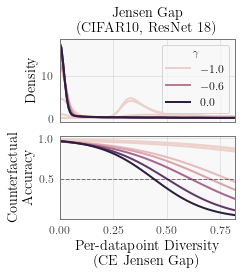

In [24]:
base_size = 3.5
fig, axs = plt.subplots(
    2, len(regularizers[:1]), figsize=(base_size * len(regularizers[:1]), base_size*4.5/4),
    sharex=True, sharey="row"
)

for i, (regularizer, (kde_ax, err_ax)) in enumerate(zip(regularizers[:1], [axs])):
    sub_plot_df = plot_df.xs(regularizer).reset_index()
#     size_dict = dict((gamma, 3. if gamma == 0. else 1.5) for gamma in sub_plot_df[r"$\gamma$"].unique())
    sns.lineplot(
        ax=kde_ax, data=sub_plot_df,
        x="Diversity", y="Density", hue=r"$\gamma$",
        legend="brief",
#         size=r"$\gamma$", sizes=size_dict,
    )
    sns.lineplot(
        ax=err_ax, data=sub_plot_df,
        x="Diversity", y=r"Counterfactual Accuracy", hue=r"$\gamma$",
        legend=False,
#         size=r"$\gamma$", sizes=size_dict,
    )
    err_ax.axhline(0.5, ls="--", lw=1., color="k", alpha=0.5)

    kde_ax.set(
        xlim=(sub_plot_df["Diversity"].min(), sub_plot_df["Diversity"].max()),
        title=f"{regularizer}\n(CIFAR10, {model})"
    )
    err_ax.set(
        xlabel="Per-datapoint Diversity\n(CE Jensen Gap)",
    )
    
    handles, labels = kde_ax.get_legend_handles_labels()
    if len(labels) > 5:
        indices = np.linspace(0, len(labels) - 1, 3).astype(int).tolist()
        handles = [handles[i] for i in indices]
        labels = [labels[i] for i in indices]
    kde_ax.get_legend().remove()
    kde_ax.legend(handles, labels, title=r"$\gamma$", loc="upper right")

    if i == 0:
        err_ax.set(ylabel="Counterfactual\n Accuracy")
        
fig.tight_layout()

In [110]:
sub_plot_df

,$\gamma$,Diversity,Density,Counterfactual Accuracy
0,-9.0,0.000000,0.011009,0.979163
1,-9.0,0.008211,0.016271,0.978799
2,-9.0,0.016422,0.022268,0.978429
3,-9.0,0.024634,0.028395,0.978053
4,-9.0,0.032845,0.033763,0.977671
...,...,...,...,...
702,0.0,0.788276,0.043125,0.061797
703,0.0,0.796487,0.045135,0.058188
704,0.0,0.804698,0.046932,0.054778
705,0.0,0.812910,0.047835,0.051557


In [25]:
fig.savefig("counterfactual_accuracy_vs_diversity_cifar10_resnet18_jg.pdf", transparent=True)

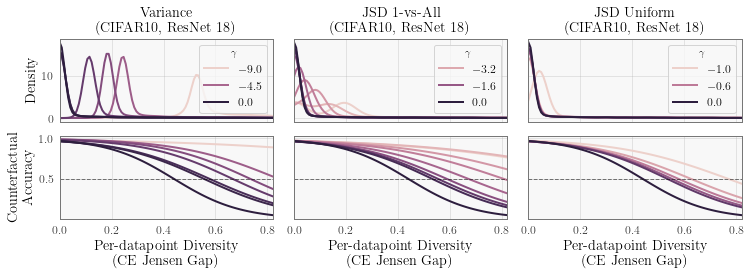

In [26]:
base_size = 3.5
fig, axs = plt.subplots(
    2, len(regularizers[1:]), figsize=(base_size * len(regularizers[1:]), base_size*4.5/4),
    sharex=True, sharey="row"
)

for i, (regularizer, (kde_ax, err_ax)) in enumerate(zip(regularizers[1:], axs.T)):
    sub_plot_df = plot_df.xs(regularizer).reset_index()
#     size_dict = dict((gamma, 3. if gamma == 0. else 1.5) for gamma in sub_plot_df[r"$\gamma$"].unique())
    sns.lineplot(
        ax=kde_ax, data=sub_plot_df,
        x="Diversity", y="Density", hue=r"$\gamma$",
        legend="brief",
#         size=r"$\gamma$", sizes=size_dict,
    )
    sns.lineplot(
        ax=err_ax, data=sub_plot_df,
        x="Diversity", y=r"Counterfactual Accuracy", hue=r"$\gamma$",
        legend=False,
#         size=r"$\gamma$", sizes=size_dict,
    )
    err_ax.axhline(0.5, ls="--", lw=1., color="k", alpha=0.5)

    kde_ax.set(
        xlim=(sub_plot_df["Diversity"].min(), sub_plot_df["Diversity"].max()),
        title=f"{regularizer}\n(CIFAR10, {model})"
    )
    err_ax.set(
        xlabel="Per-datapoint Diversity\n(CE Jensen Gap)",
    )
    
    handles, labels = kde_ax.get_legend_handles_labels()
    if len(labels) >= 5:
        indices = np.linspace(0, len(labels) - 1, 3).astype(int).tolist()
        handles = [handles[i] for i in indices]
        labels = [labels[i] for i in indices]
    kde_ax.get_legend().remove()
    kde_ax.legend(handles, labels, title=r"$\gamma$", loc="upper right")

    if i == 0:
        err_ax.set(ylabel="Counterfactual\n Accuracy")
        
fig.tight_layout()

In [27]:
fig.savefig("counterfactual_accuracy_vs_diversity_cifar10_resnet18_additional.pdf", transparent=True)

In [28]:
model = "ResNet 18"
regularizers = ["Jensen Gap", "Variance", "JSD 1-vs-All", "JSD Uniform"]

for i, regularizer in enumerate(regularizers):
    sub_df = only_reg_df.loc[model, regularizer]
    for (gamma, sub_sub_df) in sub_df.groupby(r"$\gamma$"):
        # Indep variable: diversity
        lower = sub_sub_df["Diversity"].quantile(0.05)
        upper = sub_sub_df["Diversity"].quantile(0.95)
        sub_sub_df = sub_sub_df[
            (sub_sub_df["Diversity"] >= lower) &
            (sub_sub_df["Diversity"] <= upper)
        ]
        sub_sub_df
        print(regularizer, gamma, lower, upper, sub_sub_df["Orig. Acc."].mean(), sub_sub_df["Orig. Acc."].mean())

Jensen Gap -1.0 2.5510787963867188e-05 1.0159325420856453 0.95867586 0.95867586
Jensen Gap -0.999 0.31116155683994295 1.0530761957168577 0.96844447 0.96844447
Jensen Gap -0.99 2.5033950805664062e-06 0.9977000951766966 0.9549889 0.9549889
Jensen Gap -0.9 1.5497207641601562e-06 0.6257574975490569 0.9608126 0.9608126
Jensen Gap -0.8 1.430511474609375e-06 0.5462700873613342 0.9630735 0.9630735
Jensen Gap -0.5 1.7881393432617188e-06 0.4317760944366452 0.9626874 0.9626874
Jensen Gap -0.2 1.7881393432617188e-06 0.37443691194057355 0.9634308 0.9634308
Jensen Gap 0.0 1.7881393432617188e-06 0.36038857102394073 0.9700552 0.9700552
Variance -9.0 0.46687649190425873 0.8951786279678343 0.9672222 0.9672222
Variance -4.0 0.22235673367977143 0.6397159337997429 0.9687778 0.9687778
Variance -3.0 0.17155740261077881 0.5749321997165678 0.9716667 0.9716667
Variance -2.0 0.10051486790180206 0.5386857867240905 0.9686667 0.9686667
Variance -1.0 2.0265579223632812e-06 0.43088206946849605 0.962926 0.962926
Varia

/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/2893907709.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = only_reg_df.loc[model, regularizer]


# Small Neural Network Counterfactual. 

In [30]:
dset = CIFAR10(root="/Users/taigaabe/Code/cifar10_ood/data", train=False,)
labels = torch.tensor(dset.targets)
# labels = torch.load("cifar10_labels.pth")
one_hot = torch.nn.functional.one_hot(labels).unsqueeze(-3)
one_hot.shape

torch.Size([1, 10000, 10])

In [31]:
data_dir = "/Users/taigaabe/Code/ensemble_attention/results/"
model_paths = {}
model_paths["ResNet 8", "No Regularizer"] = [
    data_dir+"dkl_resnet8_indiv/ensemble_dkl_model_0_gamma_1_resnet8_ind_preds.npy",
    data_dir+"dkl_resnet8_indiv/ensemble_dkl_model_1_gamma_1_resnet8_ind_preds.npy",
    data_dir+"dkl_resnet8_indiv/ensemble_dkl_model_2_gamma_1_resnet8_ind_preds.npy",
    data_dir+"dkl_resnet8_indiv/ensemble_dkl_model_3_gamma_1_resnet8_ind_preds.npy",
]
model_paths["ResNet 8", "Jensen Gap"] = data_dir+"dkl_resnet8_indiv"
# model_paths["ResNet 18", "Variance"] = data_dir+"var_indiv"
# model_paths["ResNet 18", "JSD 1-vs-All"] = data_dir+"js_avg_indiv_true_resnet18_cifar10/"
model_paths["ResNet 8", "JSD Uniform"] = data_dir+"js_avg_resnet8_indiv"

df = []

for (model, regularizer), path in model_paths.items():
    if isinstance(path, str):
        basenames = [
            basename for basename in os.listdir(path)
            if all([
                basename.endswith("ind_preds.npy"),
                any([f"model_{i}_" in basename for i in range(4)]),
                model.replace(" ", "").lower() in basename,
            ])
        ]
    else:
        basenames = path
        path = ""
    
    logit_dict = defaultdict(list)
    for basename in basenames:
        if "gamma" in basename:
            gamma = float(basename.split("gamma_")[1].split("_")[0]) - 1
        else:
            gamma = float(basename.split("model_")[1].split("_")[1])
        gamma = float(round(gamma * 1000)) / 1000.
        if regularizer == "Variance":
            gamma = -gamma
        if gamma >= 0. and regularizer != "No Regularizer":
            continue
        logit_dict[gamma].append(torch.tensor(np.load(os.path.join(path, basename))))
    
    sub_df = []
    print(sorted(logit_dict.keys()))
    for gamma in sorted(logit_dict.keys()):
        logits = torch.stack(logit_dict[gamma])
        arange = torch.arange(logits.size(-2), device=logits.device)
        
        # Compute avg. single model performance
        single_model_acc = (logits.argmax(dim=-1) == labels).to(logits.dtype).mean(dim=-2)
        ces = torch.logsumexp(logits, dim=-1) - logits[..., arange, labels]
        avg_ces = ces.mean(dim=-2)
        
        # Compute ensemble performance
        probs = torch.softmax(logits, dim=-1).mean(dim=-3)
        acc = (probs.argmax(dim=-1) == labels).to(logits.dtype)
        ens_ces = math.log(ces.shape[-2]) - torch.logsumexp(ces.mul(-1.), dim=-2)
    
        # Compute diversity
        jensen_gaps = avg_ces - ens_ces
        if jensen_gaps.min() < -1e-5:
            raise
            
        # Put result in a dataframe
        index = pd.MultiIndex.from_product(
            [[model], [regularizer], [gamma], arange.cpu().numpy()],
            names=["Model", "Regularizer", r"$\gamma$", "$i$"]
        )
        sub_df.append(
            pd.DataFrame(
                torch.stack([single_model_acc, acc, avg_ces, ens_ces, jensen_gaps], dim=-1),
                columns=["Single Model Acc.", "Acc.", "Avg. CE", "Ens. CE", "Diversity"],
                index=index
            )
        )
   
    # Compile sub_df
    sub_df = pd.concat(sub_df, axis=0)
    df.append(sub_df)
    
# Concatenate all results
df = pd.concat(df, axis=0)

# Get orig acc, CE
df["Orig. Single Model Acc."] = (
    df["Single Model Acc."] - df["Single Model Acc."] +
    df.loc[:, "No Regularizer", 0., :]["Single Model Acc."]
).reorder_levels(sub_df.index.names)
df["Orig. Acc."] = (
    df["Acc."] - df["Acc."] + df.loc[:, "No Regularizer", 0., :]["Acc."]
).reorder_levels(sub_df.index.names)
df["Orig. Ens. CE"] = (
    df["Ens. CE"] - df["Ens. CE"] + df.loc[:, "No Regularizer", 0., :]["Ens. CE"]
).reorder_levels(sub_df.index.names)

# Done!
df

[0.0]
[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]
[-4.9, -4.4, -3.9, -3.4, -2.9, -2.4, -1.8, -1.4, -0.6, -0.2]


Single Model Acc.  Acc.   Avg. CE  \
Model    Regularizer    $\gamma$ $i$                                       
ResNet 8 No Regularizer  0.0     0                  1.00   1.0  0.911770   
                                 1                  0.50   1.0  0.730345   
                                 2                  1.00   1.0  0.231036   
                                 3                  0.75   0.0  1.005540   
                                 4                  1.00   1.0  0.171695   
...                                                  ...   ...       ...   
         JSD Uniform    -0.2     9995               0.25   0.0  1.544123   
                                 9996               1.00   1.0  0.873150   
                                 9997               1.00   1.0  0.500529   
                                 9998               1.00   1.0  0.412064   
                                 9999               1.00   1.0  0.117177   

                                        Ens. CE  Diversity  \
Model    Regularizer    $\gamma$ $i$                         
ResNet 8 No Regularizer  0.0     0     0.911647   0.000123   
                                 1     0.708478   0.021867   
                                 2     0.229245   0.001792   
                                 3     0.993514   0.012026   
                                 4     0.170595   0.001099   
...                                         ...        ...   
         JSD Uniform    -0.2     9995  1.498676   0.045447   
                                 9996  0.865018   0.008132   
                                 9997  0.500253   0.000276   
                                 9998  0.407976   0.004089   
                                 9999  0.116450   0.000727   

                                       Orig. Single Model Acc.  Orig. Acc.  \
Model    Regularizer    $\gamma$ $i$                                         
ResNet 8 No Regularizer  0.0     0                        1.00         1.0   
                                 1                        0.50         1.0   
                                 2                        1.00         1.0   
                                 3                        0.75         0.0   
                                 4                        1.00         1.0   
...                                                        ...         ...   
         JSD Uniform    -0.2     9995                     0.00         0.0   
                                 9996                     1.00         1.0   
                                 9997                     1.00         1.0   
                                 9998                     1.00         1.0   
                                 9999                     1.00         1.0   

                                       Orig. Ens. CE  
Model    Regularizer    $\gamma$ $i$                  
ResNet 8 No Regularizer  0.0     0          0.911647  
                                 1          0.708478  
                                 2          0.229245  
                                 3          0.993514  
                                 4          0.170595  
...                                              ...  
         JSD Uniform    -0.2     9995       1.648648  
                                 9996       0.823710  
                                 9997       0.491429  
                                 9998       0.603824  
                                 9999       0.099420  

[210000 rows x 8 columns]

In [32]:
# Get rid of no regularizer, add it to other models
no_reg_df = df.xs("No Regularizer", level="Regularizer")
only_reg_df = df.drop("No Regularizer", level="Regularizer", axis=0)
no_reg_dfs = []
for regularizer in set(df.index.get_level_values("Regularizer")):
    sub_no_reg_df = no_reg_df.copy()
    sub_no_reg_df["Regularizer"] = regularizer
    sub_no_reg_df.set_index(["Regularizer"], append=True, inplace=True)
    sub_no_reg_df = sub_no_reg_df.reorder_levels(only_reg_df.index.names)
    no_reg_dfs.append(sub_no_reg_df)
only_reg_df = pd.concat([only_reg_df] + no_reg_dfs, axis=0)
only_reg_df

Single Model Acc.  Acc.   Avg. CE  \
Model    Regularizer $\gamma$ $i$                                       
ResNet 8 Jensen Gap  -1.0     0                  0.25   1.0  1.997095   
                              1                  0.50   1.0  2.039823   
                              2                  0.50   1.0  1.651533   
                              3                  0.25   0.0  2.006265   
                              4                  0.50   1.0  1.698078   
...                                               ...   ...       ...   
         JSD Uniform  0.0     9995               0.00   0.0  1.657106   
                              9996               1.00   1.0  0.830004   
                              9997               1.00   1.0  0.491723   
                              9998               1.00   1.0  0.618645   
                              9999               1.00   1.0  0.099947   

                                     Ens. CE  Diversity  \
Model    Regularizer $\gamma$ $i$                         
ResNet 8 Jensen Gap  -1.0     0     1.216796   0.780299   
                              1     0.766825   1.272997   
                              2     0.842006   0.809527   
                              3     1.397600   0.608665   
                              4     0.690586   1.007492   
...                                      ...        ...   
         JSD Uniform  0.0     9995  1.648648   0.008458   
                              9996  0.823710   0.006293   
                              9997  0.491429   0.000294   
                              9998  0.603824   0.014821   
                              9999  0.099420   0.000528   

                                    Orig. Single Model Acc.  Orig. Acc.  \
Model    Regularizer $\gamma$ $i$                                         
ResNet 8 Jensen Gap  -1.0     0                        1.00         1.0   
                              1                        0.50         1.0   
                              2                        1.00         1.0   
                              3                        0.75         0.0   
                              4                        1.00         1.0   
...                                                     ...         ...   
         JSD Uniform  0.0     9995                     0.00         0.0   
                              9996                     1.00         1.0   
                              9997                     1.00         1.0   
                              9998                     1.00         1.0   
                              9999                     1.00         1.0   

                                    Orig. Ens. CE  
Model    Regularizer $\gamma$ $i$                  
ResNet 8 Jensen Gap  -1.0     0          0.911647  
                              1          0.708478  
                              2          0.229245  
                              3          0.993514  
                              4          0.170595  
...                                           ...  
         JSD Uniform  0.0     9995       1.648648  
                              9996       0.823710  
                              9997       0.491429  
                              9998       0.603824  
                              9999       0.099420  

[230000 rows x 8 columns]

In [33]:
model = "ResNet 8"
regularizers = ["Jensen Gap", "JSD Uniform"]
range_poly= 2
plot_df = []

for i, regularizer in enumerate(regularizers):
    sub_df = only_reg_df.loc[model, regularizer]
    for (gamma, sub_sub_df) in sub_df.groupby(r"$\gamma$"):
        # Indep variable: diversity
        x = sub_sub_df["Diversity"].values
    
        # Dependent variable: model errors
        accs = sub_sub_df["Orig. Single Model Acc."].values
#         accs = sub_sub_df["Orig. Acc."].values
        x = np.repeat(x, 4, axis=-1)
        y = (accs[..., None] > (np.arange(4) / 4)).reshape([-1])
        
        # Fit logitstic regression model to errors
        X = np.stack([np.power(x, i) for i in range(range_poly)], axis=-1)
        m = LogisticRegression(penalty="l2", fit_intercept=False)
        m.fit(X, y)

        # Get x values
        xmin = 0.
        xmax = df.loc[model, "No Regularizer"]["Diversity"].quantile(0.99)
        xs = np.linspace(xmin, xmax, 101)
        
        # Get KDE estimate
        density = scipy.stats.gaussian_kde(x)(xs)
        
        # Get expected error
        Xs = np.stack([np.power(xs, i) for i in range(range_poly)], axis=-1)
        e_error = m.predict_proba(Xs)[:, 1]
        
        # Add to data frame
        index = pd.MultiIndex.from_product(
            [[regularizer], [gamma], xs],
            names=["Regularizer", r"$\gamma$", "Diversity"],
        )
        sub_plot_df = pd.DataFrame(
            np.stack([density, e_error], axis=-1),
            columns=["Density", r"Counterfactual Accuracy"],
            index=index,
        )
        plot_df.append(sub_plot_df)
        
plot_df = pd.concat(plot_df)

/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/304575772.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  sub_df = only_reg_df.loc[model, regularizer]
/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/304575772.py:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  xmax = df.loc[model, "No Regularizer"]["Diversity"].quantile(0.99)
/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/304575772.py:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  xmax = df.loc[model, "No Regularizer"]["Diversity"].quantile(0.99)
/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/304575772.py:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  xmax = df.loc[model, "No Regularizer"]["Diversity"].quantile(0.99)
/var/folders/1f/b2_sjx654d35kr09mh0stb5r0000gn/T/ipykernel_1899/304575772.py:25: PerformanceWarning: indexing past lexsort depth may im

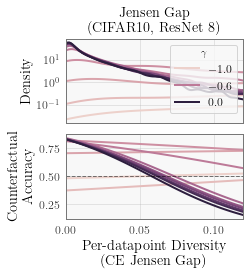

In [34]:
base_size = 3.5
fig, axs = plt.subplots(
    2, len(regularizers[:1]), figsize=(base_size * len(regularizers[:1]), base_size*4.5/4),
    sharex=True, sharey="row"
)

for i, (regularizer, (kde_ax, err_ax)) in enumerate(zip(regularizers[:2], [axs])):
    sub_plot_df = plot_df.xs(regularizer).reset_index()
#     size_dict = dict((gamma, 3. if gamma == 0. else 1.5) for gamma in sub_plot_df[r"$\gamma$"].unique())
    sns.lineplot(
        ax=kde_ax, data=sub_plot_df,
        x="Diversity", y="Density", hue=r"$\gamma$",
        legend="brief",
#         size=r"$\gamma$", sizes=size_dict,
    )
    sns.lineplot(
        ax=err_ax, data=sub_plot_df,
        x="Diversity", y=r"Counterfactual Accuracy", hue=r"$\gamma$",
        legend=False,
#         size=r"$\gamma$", sizes=size_dict,
    )
    err_ax.axhline(0.5, ls="--", lw=1., color="k", alpha=0.5)

    kde_ax.set(
        xlim=(sub_plot_df["Diversity"].min(), sub_plot_df["Diversity"].max()),
        title=f"{regularizer}\n(CIFAR10, {model})"
    )
    err_ax.set(
        xlabel="Per-datapoint Diversity\n(CE Jensen Gap)",
    )
    kde_ax.set_yscale("log")


    handles, labels = kde_ax.get_legend_handles_labels()
    if len(labels) >= 5:
        indices = np.linspace(0, len(labels) - 1, 3).astype(int).tolist()
        handles = [handles[i] for i in indices]
        labels = [labels[i] for i in indices]
    kde_ax.get_legend().remove()
    kde_ax.legend(handles, labels, title=r"$\gamma$", loc="upper right")

    if i == 0:
        err_ax.set(ylabel="Counterfactual\n Accuracy")
        
fig.tight_layout()

In [35]:
fig.savefig("counterfactual_accuracy_vs_diversity_cifar10_resnet8_jg.pdf", transparent=True)

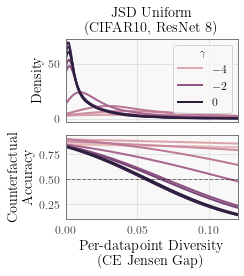

In [37]:
base_size = 3.5
fig, axs = plt.subplots(
    2, len(regularizers[1:]), figsize=(base_size * len(regularizers[1:]), base_size*4.5/4),
    sharex=True, sharey="row"
)

for i, (regularizer, (kde_ax, err_ax)) in enumerate(zip(regularizers[1:], [axs])):
    sub_plot_df = plot_df.xs(regularizer).reset_index()
#     size_dict = dict((gamma, 3. if gamma == 0. else 1.5) for gamma in sub_plot_df[r"$\gamma$"].unique())
    sns.lineplot(
        ax=kde_ax, data=sub_plot_df,
        x="Diversity", y="Density", hue=r"$\gamma$",
        legend="brief",
#         size=r"$\gamma$", sizes=size_dict,
    )
    sns.lineplot(
        ax=err_ax, data=sub_plot_df,
        x="Diversity", y=r"Counterfactual Accuracy", hue=r"$\gamma$",
        legend=False,
#         size=r"$\gamma$", sizes=size_dict,
    )
    err_ax.axhline(0.5, ls="--", lw=1., color="k", alpha=0.5)

    kde_ax.set(
        xlim=(sub_plot_df["Diversity"].min(), sub_plot_df["Diversity"].max()),
        title=f"{regularizer}\n(CIFAR10, {model})"
    )
    err_ax.set(
        xlabel="Per-datapoint Diversity\n(CE Jensen Gap)",
    )
    
    handles, labels = kde_ax.get_legend_handles_labels()
    if len(labels) >= 5:
        indices = np.linspace(0, len(labels) - 1, 3).astype(int).tolist()
        handles = [handles[i] for i in indices]
        labels = [labels[i] for i in indices]
    kde_ax.get_legend().remove()
    kde_ax.legend(handles, labels, title=r"$\gamma$", loc="upper right")

    if i == 0:
        err_ax.set(ylabel="Counterfactual\n Accuracy")
        
fig.tight_layout()

In [38]:
fig.savefig("counterfactual_accuracy_vs_diversity_cifar10_resnet8_additional.pdf", transparent=True)

# Random Forest Counterfactual. 


In [7]:
# Load data
data_dir = "/Users/taigaabe/Code/interp_ensembles/scripts/trees/"
target_paths = {}
tree_paths = {"single":{},"forest":{}}
for i in range(1,13):
    tree_paths["single"][i] = os.path.join(data_dir,"base_probs_depth_{}.npy".format(i))
    tree_paths["forest"][i] = os.path.join(data_dir,"probs_depth_{}.npy".format(i))
    target_paths[i] = os.path.join(data_dir,"base_ytest_depth_{}.npy".format(i)) # we could have taken the ensemble targets here, are interchangeable.


In [8]:
def kl_diversity(probs,labels):
    """Given probs of shape (models,samples, classes) and labels of shape (samples), generate a corresponding diversity measure.  

    """
    correct_class = probs[:,np.arange(len(labels)),labels.astype(int)]+1e-10 # models,samples with a bit of padding. 
    nb_models = len(probs[:,0,0])
    norm = np.sum(correct_class,axis = 0)
    diversity = np.sum(np.log(1/nb_models)-np.log(correct_class/norm),axis = 0)*(1/nb_models)
    return diversity

In [9]:
offset = 1e-10

# Put result in a dataframe
#         index = pd.MultiIndex.from_product(
#             [np.arange(1,13), np.arange(len(targets))],
#             names=["depth", "$i$"]
#         )
#         sub_df.append(
#             pd.DataFrame(
#                 torch.stack([single_model_acc, acc, avg_ces, ens_ces, jensen_gaps], dim=-1),
#                 columns=["Single Model Acc.", "Acc.", "Avg. CE", "Ens. CE", "Diversity"],
#                 index=index
#             )
            
# Iterate through each depth
sub_df = []
for i in range(1,13):
    ## add padding to avoid inf. 
    
    probs_ensemble = np.load(tree_paths["forest"][i])
    probs_ensemble += offset
    probs_ensemble /= np.sum(probs_ensemble, axis=-1, keepdims=True)

    probs_single = np.load(tree_paths["single"][i])
    probs_single += offset
    probs_single /= np.sum(probs_single, axis=-1, keepdims=True)
    targets = np.load(target_paths[i],allow_pickle=True).astype(int)
    
    diversity = kl_diversity(probs_ensemble,targets)
    acc_single = np.array(targets == np.argmax(probs_single,axis = -1))
    index = pd.MultiIndex.from_product(
        [[i], np.arange(len(targets))],
        names=["depth", "$i$"])
    
    sub_df.append(
        pd.DataFrame(
        torch.stack((torch.Tensor(diversity),torch.Tensor(acc_single)),axis=1),
        columns = ["Diversity","Orig. Model Acc"],
        index = index))

In [10]:
df = pd.concat(sub_df, axis=0)

In [11]:
df

Diversity  Orig. Model Acc
depth $i$                             
1     0      0.778607              0.0
      1      0.045926              0.0
      2      0.140366              0.0
      3      0.456759              0.0
      4      0.002343              0.0
...               ...              ...
12    9995   0.284550              1.0
      9996  12.299892              0.0
      9997   1.501017              1.0
      9998  12.665425              1.0
      9999  15.350874              1.0

[120000 rows x 2 columns]

In [12]:
depths = np.arange(1,13)
plot_df = []
range_poly = 2

# for i, depth in enumerate(depth):
#     sub_df = only_reg_df.loc[model, regularizer]
for (depth, sub_df) in df.groupby("depth"):
    # Indep variable: diversity
    x = sub_df["Diversity"].values

    # Dependent variable: model errors
    accs = sub_df["Orig. Model Acc"].values
#         accs = sub_sub_df["Orig. Acc."].values
    x = np.repeat(x, 4, axis=-1) # repeat each value 4 times. 
    y = (accs[..., None] > (np.arange(4) / 4)).reshape([-1]) # bin accuracies: is it greater than 0, 0.25, 0.5, 0,75? 
    # We therefore get 4 datapoints at each x.
    
    # Fit logitstic regression model to errors

    X = np.stack([np.power(x, i) for i in range(range_poly)], axis=-1)
    m = LogisticRegression(penalty="l2", fit_intercept=False)
    m.fit(X, y)

    # Get x values
    xmin = 0.
    xmax = sub_df["Diversity"].quantile(0.99)
    xs = np.linspace(xmin, xmax, 101)

    # Get KDE estimate
    density = scipy.stats.gaussian_kde(x)(xs)

    # Get expected error
    Xs = np.stack([np.power(xs, i) for i in range(range_poly)], axis=-1)
    e_error = m.predict_proba(Xs)[:, 1]

    # Add to data frame
    index = pd.MultiIndex.from_product(
        [[depth], xs],
        names=["depth", "Diversity"],
    )
    sub_plot_df = pd.DataFrame(
        np.stack([density, e_error], axis=-1),
        columns=["Density", r"Counterfactual Accuracy"],
        index=index,
    )
    plot_df.append(sub_plot_df)
        
plot_df = pd.concat(plot_df)

0.9805506672070132

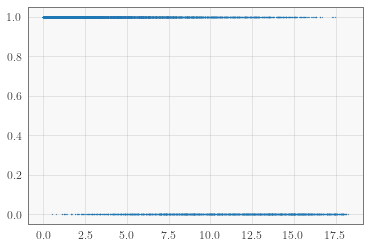

In [13]:
plt.plot(x,y,"o",markersize=0.1)
np.max(plot_df["Counterfactual Accuracy"])

In [71]:
## HACK: we change the ordering so that we can get the right color scheme (seaborn sucks.)
dfs = []
for i in range(1,13)[::-1]:
    print(i)
    sub_df = plot_df.loc[i]
    dfs.append(sub_df)
new_df = pd.concat(dfs,axis = 0,keys = [i for i in range(1,13)],names = ["depth","Diversity"])    
# new_df.loc[12]


12
11
10
9
8
7
6
5
4
3
2
1


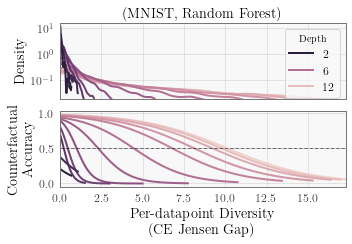

In [90]:
fig, axs = plt.subplots(
    2,1,
    sharex=True, sharey="row",figsize = (5,3.5)
)

# for depth in np.arange(1,13):
# for i, (regularizer, (kde_ax, err_ax)) in enumerate(zip(regularizers[:2], axs.T)):
sub_plot_df = new_df.reset_index()
sns.lineplot(
    ax=axs[0], data=sub_plot_df,
    x="Diversity", y="Density", hue="depth",
    legend="brief",
#     hue_order = [range(1,13)],
    )
sns.lineplot(
    ax=axs[1], data=sub_plot_df,
    x="Diversity", y=r"Counterfactual Accuracy", hue="depth",
#     hue_order = range(1,13),
    legend=False,
)
axs[1].axhline(0.5, ls="--", lw=1., color="k", alpha=0.5)


axs[0].set_yscale("log")
axs[0].set(
    xlim=(sub_plot_df["Diversity"].min(), sub_plot_df["Diversity"].max()),
    ylim=(0.02,15),
    title=f"(MNIST, Random Forest)"
)
axs[1].set(
    xlabel="Per-datapoint Diversity\n(CE Jensen Gap)",
)



handles, labels = axs[0].get_legend_handles_labels()
if len(labels) > 5:
    indices = np.linspace(0, len(labels) - 1, 3).astype(int).tolist()
    handles = [handles[i] for i in indices[::-1]]
    labels = [labels[i] for i in indices]
    axs[0].get_legend().remove()
axs[0].legend(handles, labels, title="Depth", loc="upper right")


axs[1].set(ylabel="Counterfactual\n Accuracy")
# axs[0].set_xscale('log')
fig.tight_layout()

In [91]:
fig.savefig("counterfactual_accuracy_vs_diversity_mnist_randomforest.pdf", transparent=True)

In [22]:
np.max(plot_df["Counterfactual Accuracy"].values)

0.9805506672070132